In [1]:
from skimage import io
import numpy as np
import os
import scanpy as sc
import squidpy as sq
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
import os
import gzip
import numpy as np
import celltypist
from celltypist import models


plt.rcParams['figure.dpi'] = 150
plt.rcParams['font.family'] = ['serif']
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

In [67]:
def calcQCmat(andata):
    andata.var_names_make_unique()
    andata.var["mt"] = andata.var_names.str.startswith("mt-")
    andata.var["ribo"] = andata.var_names.str.startswith(("RPS", "RPL"))
    andata.var["hb"] = andata.var_names.str.contains("^HB[^(P)]")
    sc.pp.calculate_qc_metrics(andata, qc_vars=["mt", "ribo", "hb"], inplace=True, log1p=True)
    return andata
path_016 = "/data/kanferg/Sptial_Omics/playGround/Data/Visium_HD_Mouse_Brain_square_example/square_016um"
pathout = "/data/kanferg/Sptial_Omics/SpatialOmicsToolkit/out"
andata016_ = sc.read_visium(path=path_016)
andata016_.obsm['spatial'] = np.array(andata016_.obsm['spatial'], dtype=np.float64)
andata016 = calcQCmat(andata016_)

print(f"{np.shape(andata016.X.todense())}")
sc.pp.filter_cells(andata016, min_counts = 50)
sc.pp.filter_cells(andata016, min_genes = 80)

andata016 = andata016[:,andata016.var.n_cells_by_counts > 50]
andata016 = andata016[andata016.obs["pct_counts_mt"] < 20]

sc.pp.normalize_total(andata016)
sc.pp.log1p(andata016)
log1p_data = andata016.X.todense()
sc.pp.highly_variable_genes(andata016)
sc.pp.scale(andata016)
andata016.obsm['spatial'] = np.array(andata016.obsm['spatial'], dtype=np.float64)
sc.pp.pca(andata016, n_comps=10)
sc.pp.neighbors(andata016)

sc.tl.umap(andata016)
sc.tl.leiden(andata016, key_added=f'clusters', flavor="igraph", directed=False, resolution=0.5, n_iterations=2)

sc.tl.rank_genes_groups(
    andata016, groupby="clusters", method="wilcoxon", key_added="dea_clusters"
)

/gpfs/gsfs10/users/kanferg/conda/envs/squidpy/lib/python3.10/site-packages/scanpy/readwrite.py:476: DtypeWarning: Columns (1,2,3,4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  positions = pd.read_csv(


(98917, 19059)


... storing 'feature_types' as categorical
... storing 'genome' as categorical


In [68]:
for column in andata016.obs.columns:
    if andata016.obs[column].dtype == 'object':
        andata016.obs[column] = andata016.obs[column].astype(str)

In [72]:
andata016.write_h5ad(os.path.join(pathout, 'leiden0.5_rank_16um.h5ad'))

In [56]:
andata016_

AnnData object with n_obs × n_vars = 98917 × 19059
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

In [73]:
# Define the path to the saved .h5ad file
pathout = "/data/kanferg/Sptial_Omics/SpatialOmicsToolkit/out"
file_path = os.path.join(pathout, 'leiden0.5_rank_16um.h5ad')

# Load the .h5ad file
andata016 = sc.read(file_path)

In [71]:
andata016


AnnData object with n_obs × n_vars = 97163 × 13964
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'n_counts', 'n_genes', 'clusters'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'clusters', 'dea_clusters', 'hvg', 'log1p', 'neighbors', 'pca', 'spatial', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [7]:
sq.gr.spatial_neighbors(andata016, coord_type="generic", spatial_key="spatial")
sq.gr.nhood_enrichment(andata016, cluster_key="clusters")

  0%|          | 0/1000 [00:00<?, ?/s]

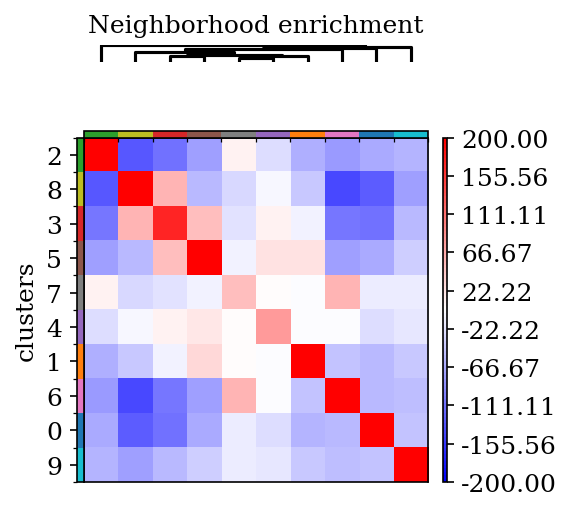

In [13]:
from matplotlib.colors import LinearSegmentedColormap

colors = [(0, 0, 1), (1, 1, 1), (1, 0, 0)]  # Blue -> White -> Red
n_bins = 100  # Discretize into 100 bins
custom_cmap = LinearSegmentedColormap.from_list('custom_cmap', colors, N=n_bins)

plt.rcParams['figure.dpi'] = 150
plt.rcParams['font.family'] = ['serif']
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

sq.pl.nhood_enrichment(
    andata016,
    cluster_key="clusters",
    method="average",
    cmap=custom_cmap,
    vmin=-200,
    vmax=200,
    figsize=(3, 3),
)


In [2]:
def calcQCmat(andata):
    andata.var_names_make_unique()
    andata.var["mt"] = andata.var_names.str.startswith("mt-")
    andata.var["ribo"] = andata.var_names.str.startswith(("RPS", "RPL"))
    andata.var["hb"] = andata.var_names.str.contains("^HB[^(P)]")
    sc.pp.calculate_qc_metrics(andata, qc_vars=["mt", "ribo", "hb"], inplace=True, log1p=True)
    return andata

In [5]:
path_016 = "/data/kanferg/Sptial_Omics/playGround/Data/Visium_HD_Mouse_Brain_square_example/square_016um"
andata016_ = sc.read_visium(path=path_016)
andata016 = calcQCmat(andata016_)
print(f"{np.shape(andata016.X.todense())}")
sc.pp.filter_cells(andata016, min_counts = 50)
sc.pp.filter_cells(andata016, min_genes = 80)
print(f"{np.shape(andata016.X.todense())}")
andata016 = andata016[andata016.obs["pct_counts_mt"] < 20]
print(f"{np.shape(andata016.X.todense())}")
sc.pp.normalize_total(andata016)
sc.pp.log1p(andata016)
sc.pp.highly_variable_genes(andata016)
sc.pp.scale(andata016)
andata016.obsm['spatial'] = np.array(andata016.obsm['spatial'], dtype=np.float64)

/gpfs/gsfs10/users/kanferg/conda/envs/squidpy/lib/python3.10/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/gpfs/gsfs10/users/kanferg/conda/envs/squidpy/lib/python3.10/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/gpfs/gsfs10/users/kanferg/conda/envs/squidpy/lib/python3.10/site-packages/scanpy/readwrite.py:476: DtypeWarning: Columns (1,2,3,4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  positions = pd.read_csv(


(98917, 19059)
(98697, 19059)
(97163, 19059)


/gpfs/gsfs10/users/kanferg/conda/envs/squidpy/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:206: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


The sc.pl.pca_variance_ratio in Scanpy library plots the variance ratio of the PCA results. It defines how much of the total variance is explained by each principal component.


/gpfs/gsfs10/users/kanferg/conda/envs/squidpy/lib/python3.10/site-packages/scanpy/preprocessing/_pca.py:374: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  warn(msg, FutureWarning)


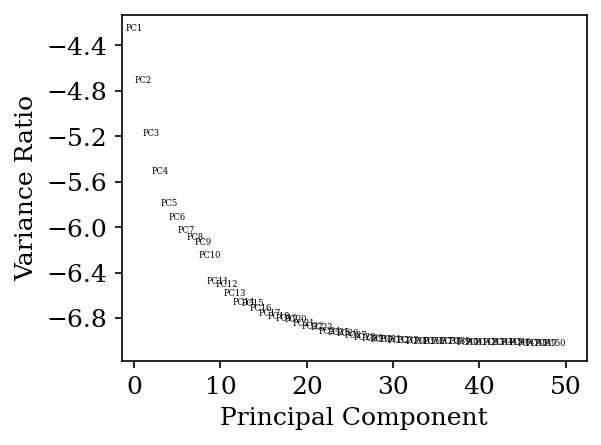

In [28]:
# first preform PCA:
sc.tl.pca(andata016, n_comps=50, use_highly_variable=True)
# then insted of using scanpy PCA ploting  
# sc.pl.pca_variance_ratio(andata016, log=True, n_pcs=50)
# creat a custom PCA ploting

import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker as ticker

# Calculate the variance ratios
pca = andata016.uns['pca']
explained_variance_ratio = np.log(pca['variance_ratio'])

# Create your own plot
plt.figure(figsize=(4,3))

n_pcs = 50

# Plot the variance ratios and label the data points
for i in range(n_pcs):
    x = i+1
    y = explained_variance_ratio[i]
    label = 'PC' + str(x)
    plt.plot(x, y, '')  # plots a blue circle marker
    plt.text(x, y, label, ha='right',fontsize = 4)  # positions text label at data point

plt.xlabel('Principal Component')
plt.ylabel('Variance Ratio')

# Specify number of ticks on the y-axis
ax = plt.gca()  # get current axes
ax.yaxis.set_major_locator(ticker.MaxNLocator(10)) 

plt.show()

In [66]:
sc.tl.pca(andata016, n_comps=5, use_highly_variable=True)

/gpfs/gsfs10/users/kanferg/conda/envs/squidpy/lib/python3.10/site-packages/scanpy/preprocessing/_pca.py:374: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  warn(msg, FutureWarning)


# Neighbors enrichment analysis

We use squidpy.gr.spatial_neighbors() for this. The function expects coord_type = 'visium' by default. We set this parameter here explicitly for clarity. n_rings should be used only for Visium datasets. It specifies for each spot how many hexagonal rings of spots around will be considered neighbors.



In [3]:
sq.gr.spatial_neighbors(andata016, n_rings=2, coord_type="grid", n_neighs=4)
#sq.gr.spatial_neighbors(andata016, n_rings=4, coord_type="generic", n_neighs=4, radius= 50, delaunay=True)
andata016.uns['neighbors'] = {
    'connectivities': andata016.obsp['spatial_connectivities'],
    'distances': andata016.obsp['spatial_distances']
}
sc.tl.leiden(andata016, key_added="clusters",flavor="igraph", directed=False, n_iterations=2)

NameError: name 'andata016' is not defined

In [7]:
#assign random clasters
andata016.obs['clusters']

s_016um_00052_00082-1     0
s_016um_00150_00268-1     1
s_016um_00144_00175-1     2
s_016um_00165_00109-1     3
s_016um_00297_00147-1     4
                         ..
s_016um_00109_00223-1    36
s_016um_00039_00175-1    37
s_016um_00037_00193-1    20
s_016um_00144_00329-1    18
s_016um_00176_00108-1    16
Name: clusters, Length: 97163, dtype: category
Categories (91, object): ['0', '1', '2', '3', ..., '87', '88', '89', '90']

/gpfs/gsfs10/users/kanferg/conda/envs/squidpy/lib/python3.10/site-packages/squidpy/pl/_spatial_utils.py:483: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = color_source_vector.map(color_map)


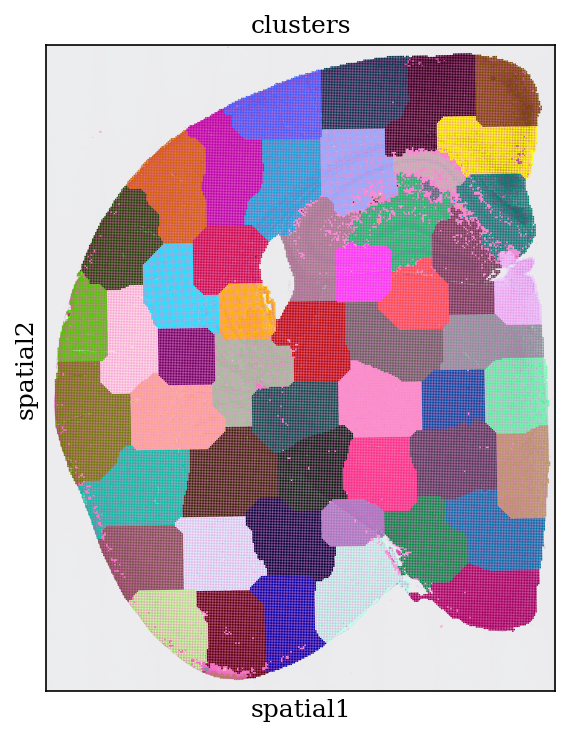

In [10]:
andata016.obsm['spatial'] = np.array(andata016.obsm['spatial'], dtype=np.float64)
ax = sq.pl.spatial_scatter(andata016, color=["clusters"])
plt.title("  ")
plt.gca().get_legend().remove()
plt.show()

/gpfs/gsfs10/users/kanferg/conda/envs/squidpy/lib/python3.10/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/gpfs/gsfs10/users/kanferg/conda/envs/squidpy/lib/python3.10/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/gpfs/gsfs10/users/kanferg/conda/envs/squidpy/lib/python3.10/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/gpfs/gsfs10/users/kanferg/conda/envs/squidpy/lib/python3.10/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  df[key] = c
/gpfs/gsfs10/users/kanferg/conda/envs/squidpy/lib/python3.10/site-packages/anndata/_core/anndata.py:1209: ImplicitMo

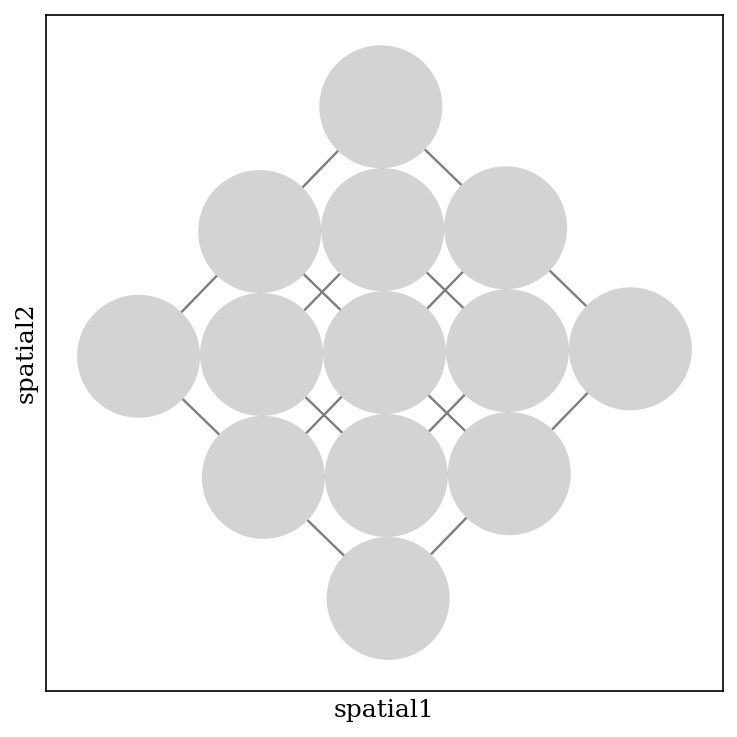

In [52]:
andata016.obsm['spatial'] = np.array(andata016.obsm['spatial'], dtype=np.float64)
_, idx = andata016.obsp["spatial_connectivities"][420, :].nonzero()

# Ensure that idx is an ndarray, and the added element is also in the form of an array
idx = np.append(idx, np.array([420]))

# Ensure `idx` is of integer dtype for indexing by casting if necessary
idx = idx.astype(int)

# Plot using spatial_scatter
sq.pl.spatial_scatter(
    andata016[idx, :],
    connectivity_key="spatial_connectivities",
    img=False,
    na_color="lightgrey",
    scale_factor=0.5,
    # Use a scale factor of 1.0, which should not alter the coordinates
)

/gpfs/gsfs10/users/kanferg/conda/envs/squidpy/lib/python3.10/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/gpfs/gsfs10/users/kanferg/conda/envs/squidpy/lib/python3.10/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/gpfs/gsfs10/users/kanferg/conda/envs/squidpy/lib/python3.10/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/gpfs/gsfs10/users/kanferg/conda/envs/squidpy/lib/python3.10/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  df[key] = c
/gpfs/gsfs10/users/kanferg/conda/envs/squidpy/lib/python3.10/site-packages/anndata/_core/anndata.py:1209: ImplicitMo

/gpfs/gsfs10/users/kanferg/conda/envs/squidpy/lib/python3.10/site-packages/squidpy/pl/_spatial_utils.py:956: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


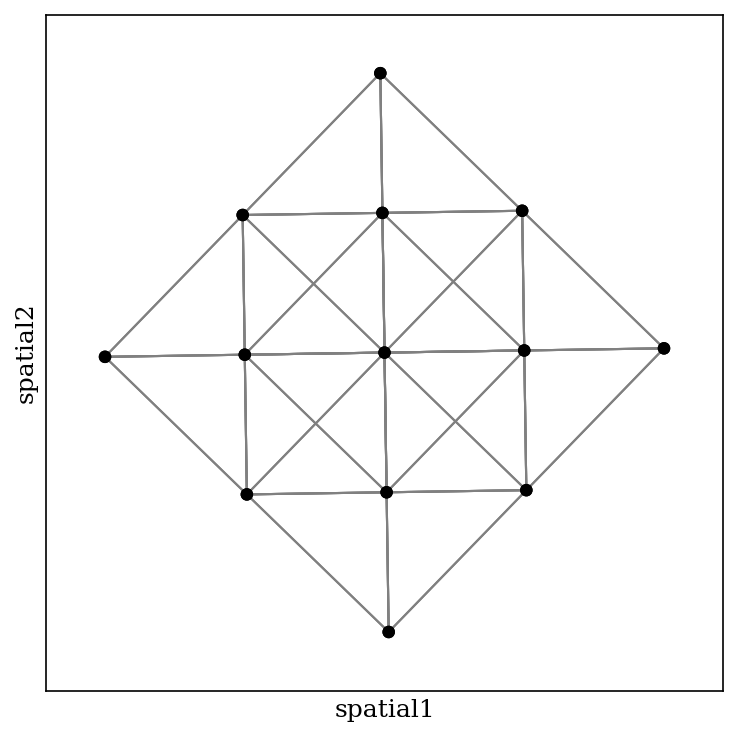

In [54]:
_, idx = andata016.obsp["spatial_connectivities"][420, :].nonzero()
idx = np.append(idx, 420)
sq.pl.spatial_scatter(
    andata016[idx, :],
    shape=None,
    color="cell type",
    connectivity_key="spatial_connectivities",
    size=100,
)

In [55]:
sc.tl.leiden(andata016, key_added="clusters", flavor="igraph", directed=False, n_iterations=2)

KeyError: 'No "neighbors" in .uns'

In [24]:
%pip install pybiomart

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.3/491.3 kB 12.6 MB/s eta 0:00:000:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.4/61.4 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 10.3 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [26]:
annot = sc.queries.biomart_annotations(
        "mmusculus",
        ["mgi_symbol", "ensembl_gene_id"],
    ).set_index("mgi_symbol")

In [27]:
annot

ensembl_gene_id
mgi_symbol                    
mt-Tf       ENSMUSG00000064336
mt-Rnr1     ENSMUSG00000064337
mt-Tv       ENSMUSG00000064338
mt-Rnr2     ENSMUSG00000064339
mt-Tl1      ENSMUSG00000064340
...                        ...
Zbp1        ENSMUSG00000027514
Pmepa1      ENSMUSG00000038400
Pmepa1os    ENSMUSG00000087600
Ptprj       ENSMUSG00000025314
Ptprjos1    ENSMUSG00000085471

[57189 rows x 1 columns]

In [28]:
annot = annot[annot.index.isin(counts.columns)]
annot

NameError: name 'counts' is not defined

In [2]:
path_016 = "/data/kanferg/Sptial_Omics/playGround/Data/Visium_HD_Mouse_Brain_square_example/square_016um"
path_008 = "/data/kanferg/Sptial_Omics/playGround/Data/Visium_HD_Mouse_Brain_square_example/square_008um"
path_002 = "/data/kanferg/Sptial_Omics/playGround/Data/Visium_HD_Mouse_Brain_square_example/square_002um"
pathout = "/data/kanferg/Sptial_Omics/SpatialOmicsToolkit/out"

In [ ]:
andata002_ = sc.read_visium(path=path_002)
andata008_ = sc.read_visium(path=path_008)
andata016_ = sc.read_visium(path=path_016)

In [4]:
def calcQCmat(andata):
    andata.var_names_make_unique()
    andata.var["mt"] = andata.var_names.str.startswith("mt-")
    andata.var["ribo"] = andata.var_names.str.startswith(("RPS", "RPL"))
    andata.var["hb"] = andata.var_names.str.contains("^HB[^(P)]")
    sc.pp.calculate_qc_metrics(andata, qc_vars=["mt", "ribo", "hb"], inplace=True, log1p=True)
    return andata
andata002 = calcQCmat(andata002_)
andata008 = calcQCmat(andata008_)
andata016 = calcQCmat(andata016_)

KeyboardInterrupt: 

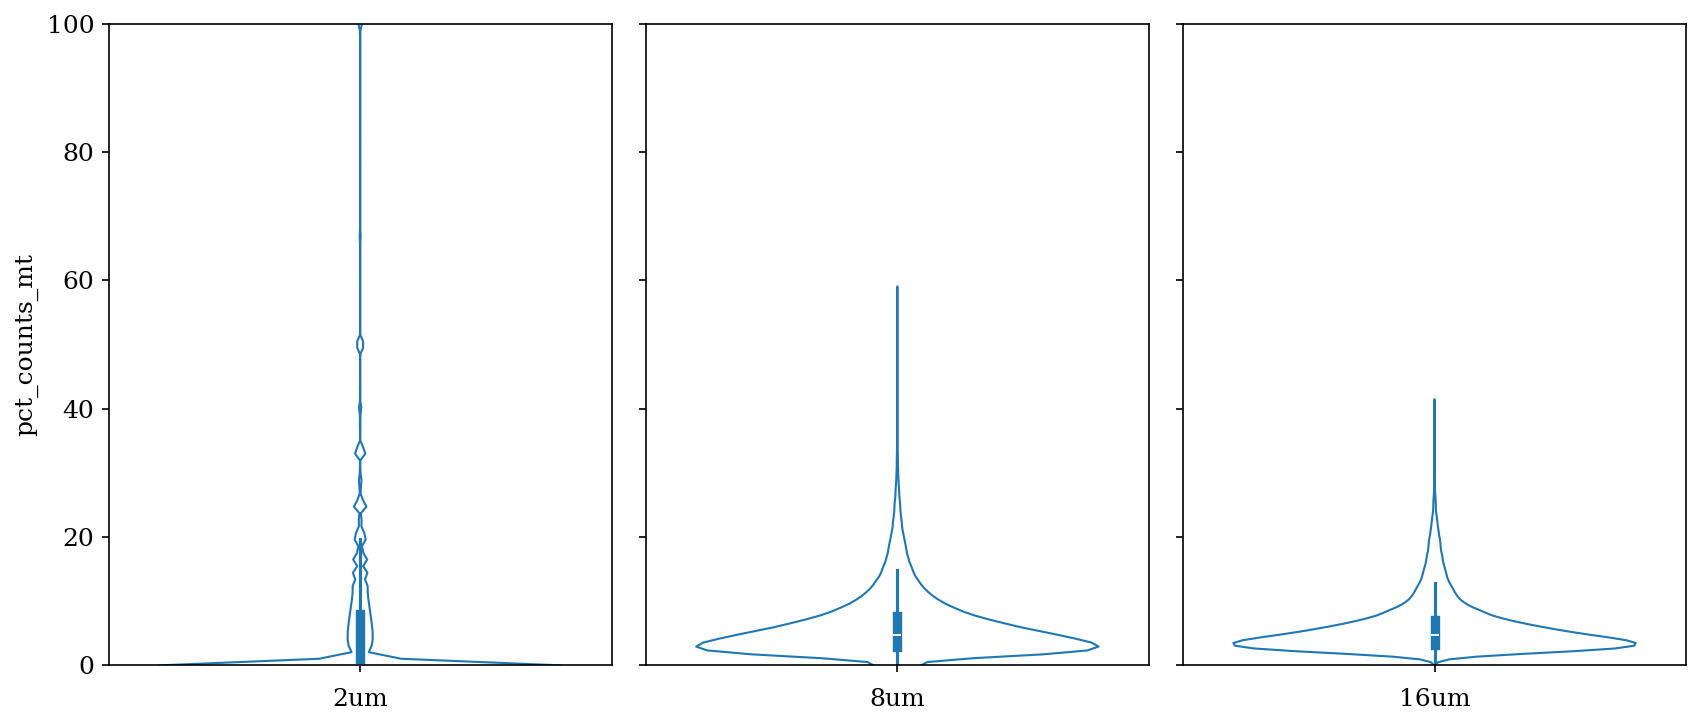

In [88]:
fig, axes = plt.subplots(1, 3,figsize=(11.5, 5),sharey=all)
axes = axes.ravel()
for ax in axes:
    ax.set_ylim(0, 100)
#sns.stripplot(y=andata002.obs['pct_counts_mt'], ax=axes[0], jitter=5, alpha=0.01, color='k',size=1)
sns.violinplot(y = andata002.obs['pct_counts_mt'], linewidth=1, linecolor="k",ax = axes[0],fill=False)
#sns.stripplot(y=andata008.obs['pct_counts_mt'], ax=axes[1], jitter=5, alpha=0.01, color='k',size=1)
sns.violinplot(y = andata008.obs['pct_counts_mt'], linewidth=1, linecolor="k",ax = axes[1],fill=False)
#sns.stripplot(y=andata016.obs['pct_counts_mt'], ax=axes[2], jitter=5, alpha=0.01, color='k',size=1)
sns.violinplot(y = andata016.obs['pct_counts_mt'], linewidth=1, linecolor="k",ax = axes[2],fill=False)
axes[0].set_xlabel("2um")
axes[1].set_xlabel("8um")
axes[2].set_xlabel("16um")
plt.tight_layout()
plt.savefig(os.path.join(pathout,'violin_plots_mito_visHD.pdf'))
plt.show()

In [3]:
andata002 = sc.read_visium(path=path_002)
#andata002 = calcQCmat(andata002_)
sc.pp.filter_cells(andata002, min_counts = 10)
andata002

/gpfs/gsfs10/users/kanferg/conda/envs/squidpy/lib/python3.10/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/gpfs/gsfs10/users/kanferg/conda/envs/squidpy/lib/python3.10/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/gpfs/gsfs10/users/kanferg/conda/envs/squidpy/lib/python3.10/site-packages/scanpy/readwrite.py:476: DtypeWarning: Columns (1,2,3,4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  positions = pd.read_csv(
/gpfs/gsfs10/users/kanferg/conda/envs/squidpy/lib/python3.10/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 2917822 × 19059
    obs: 'in_tissue', 'array_row', 'array_col', 'n_counts'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

In [4]:
andata002_01 = andata002[0:int(len(andata002)/2)]
andata002_02 = andata002[int(len(andata002)/2)+1:int(len(andata002))]

In [12]:
andata002_01 = andata002[0:1232]
andata002_01

View of AnnData object with n_obs × n_vars = 1232 × 19059
    obs: 'in_tissue', 'array_row', 'array_col', 'n_counts'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

In [9]:
def processAndata(adata):
    sc.pp.normalize_total(adata)
    sc.pp.log1p(adata)
    sc.pp.scale(adata, max_value=10)
    return adata

def make_unique(names):
    """ Ensure that names are unique by appending a suffix if needed """
    seen = set()
    result = []
    for name in names:
        count = 1
        new_name = name
        while new_name in seen:
            new_name = f"{name}_{count}"
            count += 1
        seen.add(new_name)
        result.append(new_name)
    return result

In [13]:
from tqdm import tqdm
adata = andata002_01
# Split the data into 20 batches
n_batches = 20
batch_size = len(adata) // n_batches
batches = [adata[i*batch_size:(i+1)*batch_size].copy() for i in range(n_batches)]

/gpfs/gsfs10/users/kanferg/conda/envs/squidpy/lib/python3.10/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [53]:
import numpy as np
import pandas as pd
import anndata

# Create dummy data
adata1 = anndata.AnnData(X=np.random.randn(100, 50), var=pd.DataFrame(index=[f'gene_{i}' for i in range(50)]))
adata2 = anndata.AnnData(X=np.random.randn(200, 50), var=pd.DataFrame(index=[f'gene_{i}' for i in range(50)]))
adata3 = anndata.AnnData(X=np.random.randn(150, 50), var=pd.DataFrame(index=[f'gene_{i}' for i in range(50)]))

# List of AnnData objects
processed_batches = [adata1, adata2, adata3]

# Concatenate along rows (observations)
concatenated_adata = processed_batches[0]
for adata in processed_batches[1:]:
    concatenated_adata = sc.concat(adata, join='outer', axis=1)

concatenated_adata


/gpfs/gsfs10/users/kanferg/conda/envs/squidpy/lib/python3.10/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/gpfs/gsfs10/users/kanferg/conda/envs/squidpy/lib/python3.10/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 150 × 7500

In [58]:
import anndata as ad
concatenated_adata = processed_batches[0]

for adata in processed_batches[:3]:
    concatenated_adata = sc.concat(adata, join='outer',axis=1)
concatenated_adata
# processed_adata = ad.concat(processed_batches,join='outer', axis='obs')
# processed_adata

/gpfs/gsfs10/users/kanferg/conda/envs/squidpy/lib/python3.10/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/gpfs/gsfs10/users/kanferg/conda/envs/squidpy/lib/python3.10/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/gpfs/gsfs10/users/kanferg/conda/envs/squidpy/lib/python3.10/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 61 × 1162599
    var: 'gene_ids', 'feature_types', 'genome', 'mean', 'std'

In [61]:
sc.concat([processed_batches[0],processed_batches[1]], join='outer',axis=0)

AnnData object with n_obs × n_vars = 122 × 38118
    obs: 'in_tissue', 'array_row', 'array_col', 'n_counts'
    obsm: 'spatial'

In [63]:
61*3

183

In [59]:
processed_batches

[AnnData object with n_obs × n_vars = 61 × 19059
     obs: 'in_tissue', 'array_row', 'array_col', 'n_counts'
     var: 'gene_ids', 'feature_types', 'genome', 'mean', 'std'
     uns: 'spatial', 'log1p'
     obsm: 'spatial',
 AnnData object with n_obs × n_vars = 61 × 19059
     obs: 'in_tissue', 'array_row', 'array_col', 'n_counts'
     var: 'gene_ids', 'feature_types', 'genome', 'mean', 'std'
     uns: 'spatial', 'log1p'
     obsm: 'spatial',
 AnnData object with n_obs × n_vars = 61 × 19059
     obs: 'in_tissue', 'array_row', 'array_col', 'n_counts'
     var: 'gene_ids', 'feature_types', 'genome', 'mean', 'std'
     uns: 'spatial', 'log1p'
     obsm: 'spatial',
 AnnData object with n_obs × n_vars = 61 × 19059
     obs: 'in_tissue', 'array_row', 'array_col', 'n_counts'
     var: 'gene_ids', 'feature_types', 'genome', 'mean', 'std'
     uns: 'spatial', 'log1p'
     obsm: 'spatial',
 AnnData object with n_obs × n_vars = 61 × 19059
     obs: 'in_tissue', 'array_row', 'array_col', 'n_counts'

In [56]:
from tqdm import tqdm
adata = andata002_01
# Split the data into 20 batches
n_batches = 20
batch_size = len(adata) // n_batches
batches = [adata[i*batch_size:(i+1)*batch_size].copy() for i in range(n_batches)]

# Ensure unique observation names and variable names across batches
for i, batch in enumerate(batches):
    batch.obs_names = make_unique([f"{name}_batch{i}" for name in batch.obs_names])
    batch.var_names = make_unique([f"{name}_batch{i}" for name in batch.var_names])

# Process each batch with a progress bar
processed_batches = []
for batch in tqdm(batches, desc="Processing batches"):
    processed_batch = processAndata(batch)
    processed_batches.append(processed_batch)

# # Concatenate the processed batches back into a single AnnData object
# processed_adata = sc.concat(processed_batches,join='outer')

Processing batches: 100%|██████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 56.51it/s]


In [10]:
from tqdm import tqdm
adata = andata002_01
# Split the data into 20 batches
n_batches = 20
batch_size = len(adata) // n_batches
batches = [adata[i*batch_size:(i+1)*batch_size].copy() for i in range(n_batches)]

# Ensure unique observation names and variable names across batches
for i, batch in enumerate(batches):
    batch.obs_names = make_unique([f"{name}_batch{i}" for name in batch.obs_names])
    batch.var_names = make_unique([f"{name}_batch{i}" for name in batch.var_names])

# Process each batch with a progress bar
processed_batches = []
for batch in tqdm(batches, desc="Processing batches"):
    processed_batch = processAndata(batch)
    processed_batches.append(processed_batch)

# Concatenate the processed batches back into a single AnnData object
processed_adata = sc.concat(processed_batches,join='outer')

# Save or further use the processed_adata
# processed_adata.write_h5ad('processed_data.h5ad')  # Modify this line to save your processed data

/gpfs/gsfs10/users/kanferg/conda/envs/squidpy/lib/python3.10/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
Processing batches: 100%|██████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 68.77it/s]
/tmp/ipykernel_724547/2398679378.py:20: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  processed_adata = processed_batches[0].concatenate(*processed_batches[1:], batch_key="batch")


In [11]:
processed_adata

AnnData object with n_obs × n_vars = 1220 × 0
    obs: 'in_tissue', 'array_row', 'array_col', 'n_counts', 'batch'
    var: 'gene_ids', 'feature_types', 'genome', 'mean', 'std'
    obsm: 'spatial'

In [5]:
from tqdm import tqdm
adata = andata002_02
n_batches = 20
batch_size = len(adata) // n_batches
batches = [adata[i*batch_size:(i+1)*batch_size] for i in range(n_batches)]

# Process each batch with a progress bar
processed_batches = []
for batch in tqdm(batches, desc="Processing batches"):
    processed_batch = processAndata(batch.copy())
    processed_batches.append(processed_batch)

# Optionally, concatenate the processed batches back into a single AnnData object
processed_adata_2 = processed_batches[0].concatenate(*processed_batches[1:])

/gpfs/gsfs10/users/kanferg/conda/envs/squidpy/lib/python3.10/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [ ]:
andata002.obs_names_make_unique()
sc.pp.filter_cells(andata002, min_counts = 10)
sc.pp.normalize_total(andata002)
sc.pp.log1p(andata002)
sc.pp.scale(andata002, max_value=10)

/gpfs/gsfs10/users/kanferg/conda/envs/squidpy/lib/python3.10/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [6]:
outPath = "/data/kanferg/Sptial_Omics/SpatialOmicsToolkit/out"
andata002.write(os.path.join(outPath, "example_file_060224.h5ad"))

TypeError: Can't implicitly convert non-string objects to strings

In [13]:
import random
andata002.obs_names_make_unique()
sc.pp.filter_cells(andata002, min_counts = 10)
andata002_subset = andata002[:300_000, :].copy()

In [ ]:
def filterAndata(adata,min_counts = 50, min_genes=10):
    sc.pp.filter_cells(adata, min_counts = min_counts)
    sc.pp.filter_cells(adata, min_genes = min_genes)
    sc.pp.normalize_total(adata)
    sc.pp.log1p(adata)
    sc.pp.scale(adata, max_value=10)
    # np.shape(andata016.X.todense())
    return adata

In [ ]:
filterAndata(andata008, min_counts=50, min_genes = 50)
filterAndata(andata016, min_counts=50, min_genes = 80)

In [5]:
andata002.n_obs

6296688

In [ ]:
andata002.obs_names_make_unique()
andata002

In [ ]:
sc.pp.filter_cells(andata002, min_counts = 10)

In [ ]:
np.sum(andata002.axis=todense()[:5,:5],axis = 0)

In [87]:
andata_subset = andata002[:100_000, :].copy()
andata_subset

AnnData object with n_obs × n_vars = 1000 × 19059
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'n_counts'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'spatial'
    obsm: 'spatial'

In [73]:
andata_subset.shape[0]

1000

In [18]:
from dask.distributed import Client

# Set up Dask client to use 10 workers
client = Client(n_workers=50, threads_per_worker=1, memory_limit='4GB')

/gpfs/gsfs10/users/kanferg/conda/envs/squidpy/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 33807 instead
  warnings.warn(


In [17]:
import scanpy as sc
from dask import delayed, compute
import anndata as ad

def process_chunk(chunk):
    sc.pp.normalize_total(chunk)
    sc.pp.log1p(chunk)
    sc.pp.scale(chunk, max_value=10)
    return chunk

# Split the subset into smaller chunks
def split_adata(adata, n_chunks):
    chunk_size = adata.shape[0] // n_chunks
    chunks = [adata[i*chunk_size:(i+1)*chunk_size].copy() for i in range(n_chunks)]
    # Handle the last chunk which might have remaining rows
    if adata.shape[0] % n_chunks != 0:
        chunks.append(adata[n_chunks*chunk_size:].copy())
    return chunks

# Function to merge AnnData chunks back into a single AnnData object
def merge_adata(chunks):
    combined = ad.concat(chunks)
    return combined

In [21]:
process_chunk_delayed

[AnnData object with n_obs × n_vars = 5835 × 19059
     obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'n_counts'
     var: 'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
     uns: 'spatial'
     obsm: 'spatial',
 AnnData object with n_obs × n_vars = 5835 × 19059
     obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in

In [20]:
# Split the large AnnData object into smaller chunks
n_chunks = 500  # Adjust based on your memory and CPU capacity
chunks = split_adata(andata002, n_chunks)

In [ ]:
process_chunk_delayed = delayed(process_chunk)

In [25]:
# Create delayed objects for each chunk
processed_chunks_delayed = [process_chunk_delayed(chunk) for chunk in chunks]

501

In [ ]:
# Split the large AnnData object into smaller chunks
n_chunks = 50000  # Adjust based on your memory and CPU capacity
chunks = split_adata(andata002, n_chunks)

# Wrap the processing function with Dask's delayed decorator
process_chunk_delayed = delayed(process_chunk)

# Create delayed objects for each chunk
processed_chunks_delayed = [process_chunk_delayed(chunk) for chunk in chunks]

# Compute the results in parallel, in batches
results = []
batch_size = 50  # Number of workers available
for i in range(0, len(processed_chunks_delayed), batch_size):
    # Process a batch of chunks
    batch = processed_chunks_delayed[i:i+batch_size]
    processed_batch = compute(*batch)
    results.extend(processed_batch)

# Merge the processed chunks back into a single AnnData object
andata002_processed = merge_adata(results)

# Inspect the results
print(f'andata002_processed: {andata002_processed}')

/gpfs/gsfs10/users/kanferg/conda/envs/squidpy/lib/python3.10/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 17.86 GiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/gpfs/gsfs10/users/kanferg/conda/envs/squidpy/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:233: UserWarning: Some cells have zero counts
  warn(UserWarning("Some cells have zero counts"))
/gpfs/gsfs10/users/kanferg/conda/envs/squidpy/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:233: UserWarning: Some cells have zero counts
  warn(UserWarning("Some cells have zero counts"))
/gpfs/gsfs10/users/kanferg/conda/envs/squidpy/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:233: UserWarning: Some cells have zero counts
  warn(UserWarning("Some cells have zero counts"))
/gpfs/gsfs10/users/kanferg/conda/envs/squidpy/lib/python3.10/site-packages/scanpy/preprocessing/_normalizat

/gpfs/gsfs10/users/kanferg/conda/envs/squidpy/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:233: UserWarning: Some cells have zero counts
  warn(UserWarning("Some cells have zero counts"))
2024-05-31 11:24:21,631 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 2.63 GiB -- Worker memory limit: 3.73 GiB
2024-05-31 11:24:21,655 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 2.61 GiB -- Worker memory limit: 3.73 GiB
2024-05-31 11:24:21,657 - distributed.worker.memory - WARNING - Unmanaged memory us

2024-05-31 11:24:22,432 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 2.63 GiB -- Worker memory limit: 3.73 GiB
2024-05-31 11:24:22,442 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 2.61 GiB -- Worker memory limit: 3.73 GiB
2024-05-31 11:24:22,461 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- U

2024-05-31 11:24:24,342 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 2.99 GiB -- Worker memory limit: 3.73 GiB
2024-05-31 11:24:24,347 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 2.99 GiB -- Worker memory limit: 3.73 GiB
2024-05-31 11:24:24,381 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 2.99 GiB -- Worker memory limit: 3.73 GiB
2024-05-31 11:24:24,385 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.01 GiB -- Worker memory limit: 3.73 GiB
2024-05-31 11:24:24,416 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.01 GiB -- Worker memory limit: 3.73 GiB
2024-05-31 11:24:24,431 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 2.99 GiB -- Worker mem

In [23]:
# Wrap the processing function with Dask's delayed decorator
process_chunk_delayed = delayed(process_chunk)


Delayed('process_chunk-35652b8b-1c8c-40da-a27e-6914b43a7cb0')

In [91]:
andata002_processed.X.shape

(1000, 19059)

In [95]:
#x = np.median(andata002_processed.X.todense(),axis=1)
sc.pp.normalize_total(andata002_processed)
andata002_processed

AnnData object with n_obs × n_vars = 1000 × 19059
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'n_counts'
    obsm: 'spatial'

In [99]:
x = np.sum(andata002_processed.X.todense(),axis=1)
x

matrix([[18.      ],
        [18.      ],
        [18.      ],
        [18.      ],
        [18.      ],
        [18.      ],
        [18.      ],
        [18.      ],
        [18.      ],
        [18.      ],
        [18.      ],
        [18.      ],
        [18.      ],
        [18.      ],
        [18.      ],
        [18.      ],
        [18.      ],
        [18.      ],
        [18.      ],
        [18.000002],
        [18.      ],
        [18.      ],
        [18.      ],
        [18.      ],
        [18.      ],
        [18.      ],
        [18.      ],
        [18.      ],
        [18.      ],
        [18.      ],
        [18.      ],
        [18.      ],
        [18.      ],
        [18.      ],
        [18.      ],
        [18.      ],
        [18.      ],
        [18.000002],
        [18.      ],
        [18.      ],
        [18.      ],
        [18.      ],
        [18.      ],
        [18.      ],
        [18.      ],
        [18.      ],
        [18.000002],
        [18. 

In [78]:
sns.histplot(np.median(andata002_processed.X.todense(),axis=0),kde = True)


<Axes: ylabel='Count'>

/gpfs/gsfs10/users/kanferg/conda/envs/squidpy/lib/python3.10/site-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/gpfs/gsfs10/users/kanferg/conda/envs/squidpy/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


Error in callback <function flush_figures at 0x15539a11c790> (for post_execute):


KeyboardInterrupt: 

In [8]:
andata002_test = sc.pp.normalize_total(andata002,target_sum=1, exclude_highly_expressed=True,
    max_fraction=0.2, inplace=False)

MemoryError: Unable to allocate 447. GiB for an array with shape (6296688, 19059) and data type float32

In [ ]:
sc.pp.normalize_total(andata002)
sc.pp.log1p(andata002)
sc.pp.scale(andata002, max_value=10)
andata002

In [ ]:
def filterAndata(adata,min_counts = 50, min_genes=10):
    sc.pp.filter_cells(adata, min_counts = min_counts)
    sc.pp.filter_cells(adata, min_genes = min_genes)
    sc.pp.normalize_total(adata)
    sc.pp.log1p(adata)
    sc.pp.scale(adata, max_value=10)
    # np.shape(andata016.X.todense())
    return adata
filterAndata(andata002, min_counts = 10, min_genes = 0)
#filterAndata(andata008, min_counts=50, min_genes = 50)
#filterAndata(andata016, min_counts=50, min_genes = 80)

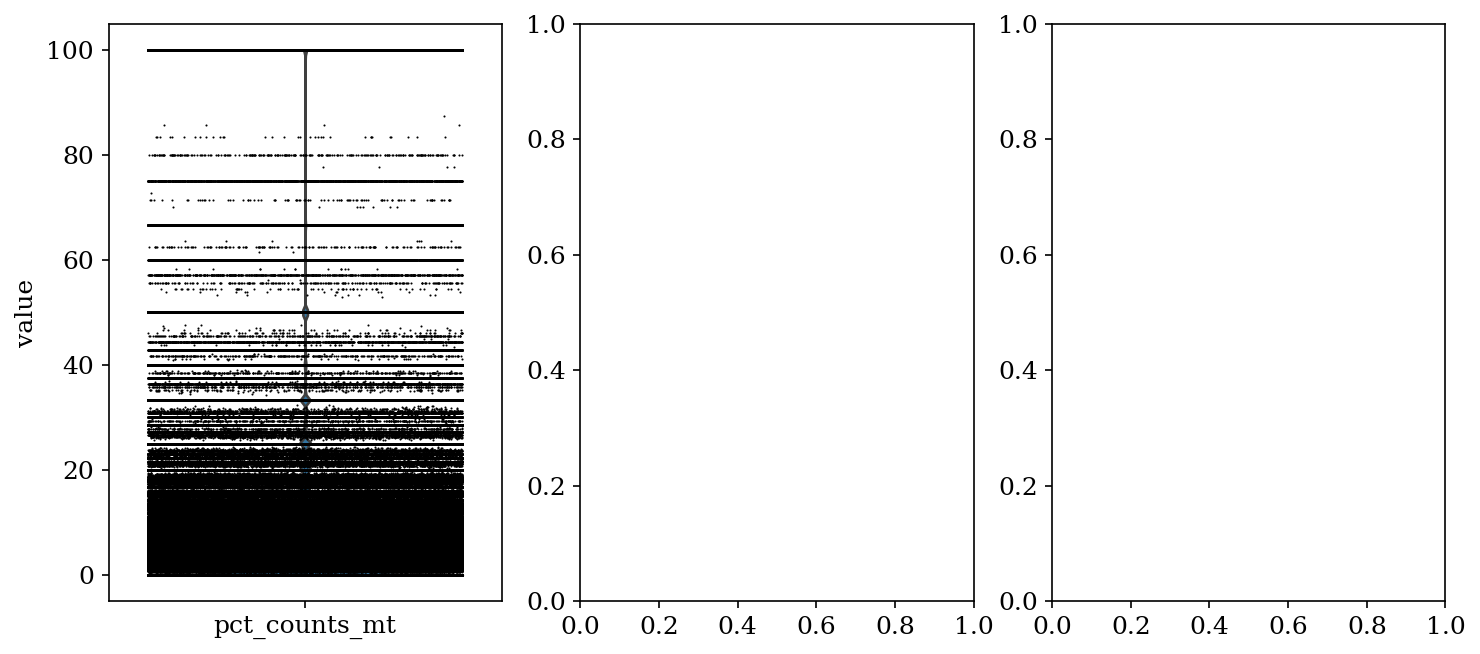

In [59]:
fig, axes = plt.subplots(1, 3,figsize=(11.5, 5))
axes = axes.ravel()
sc.pl.violin(andata002,keys = ["pct_counts_mt"],jitter=0.4,multi_panel=True,ax = axes[0])
sc.pl.violin(andata008,keys = ["pct_counts_mt"],jitter=0.4,multi_panel=True,ax = axes[1])
sc.pl.violin(andata016,["pct_counts_mt"],jitter=0.4,multi_panel=True,ax = axes[2])

plt.tight_layout()
#Save the figure as a PDF
plt.savefig('violin_plots_mito_visHD.pdf', format='pdf')
plt.show()

TypeError: Data source must be a DataFrame or Mapping, not <class 'anndata._core.anndata.AnnData'>.

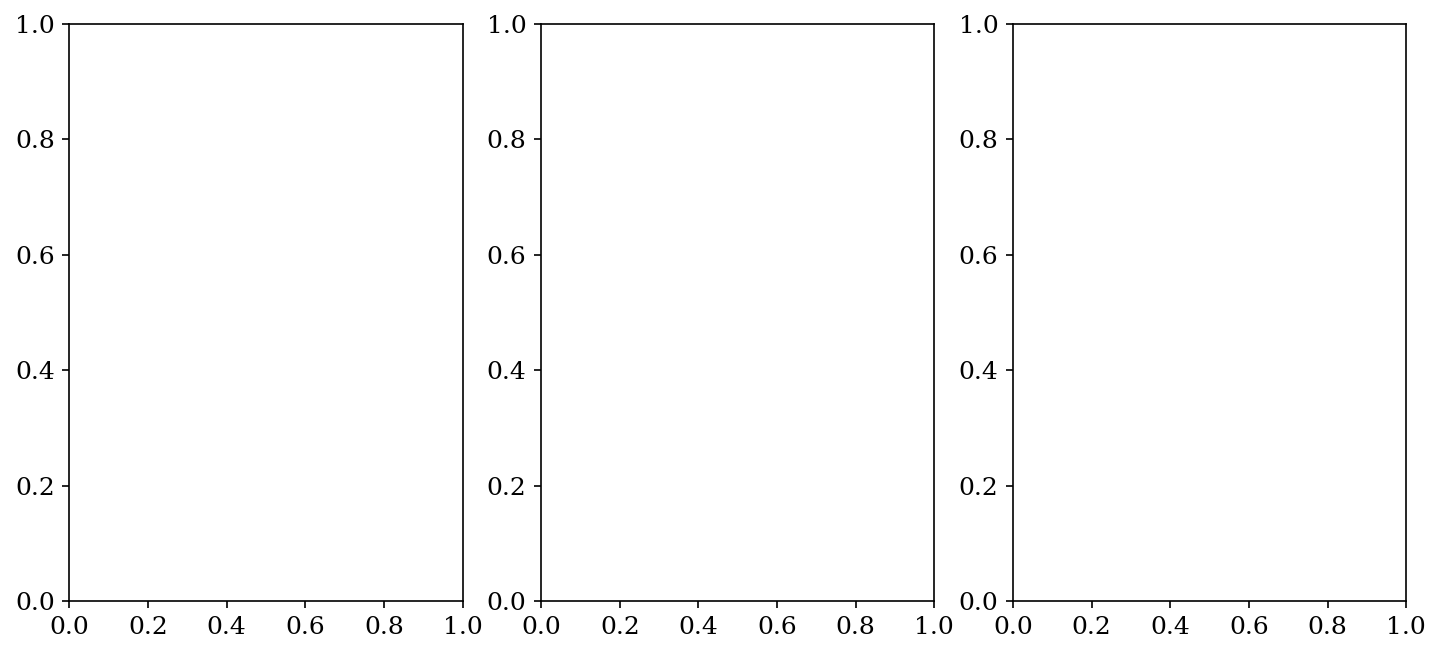

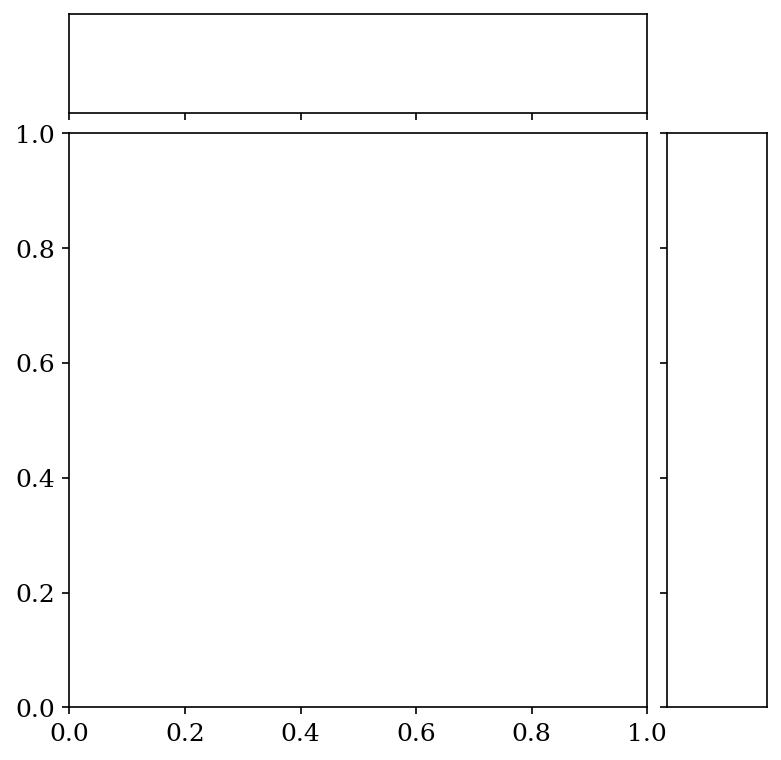

In [17]:
fig, axes = plt.subplots(1, 3,figsize=(11.5, 5))
axes = axes.ravel()
g1 = sns.jointplot(data=andata016,x="log1p_total_counts",y="log1p_n_genes_by_counts",kind="hex")
g1.fig.set_figwidth(4)
g1.fig.set_figheight(5)
for ax in g1.fig.axes:
    fig._axstack.add(fig._make_key(ax), ax)
    fig.axes.append(ax)
    fig.sca(ax)
axs[0].remove()


g2 = sns.jointplot(data=andata016,x="log1p_total_counts",y="log1p_n_genes_by_counts",kind="hex")
g2.fig.set_figwidth(4)
g2.fig.set_figheight(5)
for ax in g2.fig.axes:
    fig._axstack.add(fig._make_key(ax), ax)
    fig.axes.append(ax)
    fig.sca(ax)
axs[1].remove()


g3 = sns.jointplot(data=andata016,x="log1p_total_counts",y="log1p_n_genes_by_counts",kind="hex")
g3.fig.set_figwidth(4)
g3.fig.set_figheight(5)
for ax in g3.fig.axes:
    fig._axstack.add(fig._make_key(ax), ax)
    fig.axes.append(ax)
    fig.sca(ax)
axs[2].remove()

AttributeError: 'Figure' object has no attribute '_make_key'

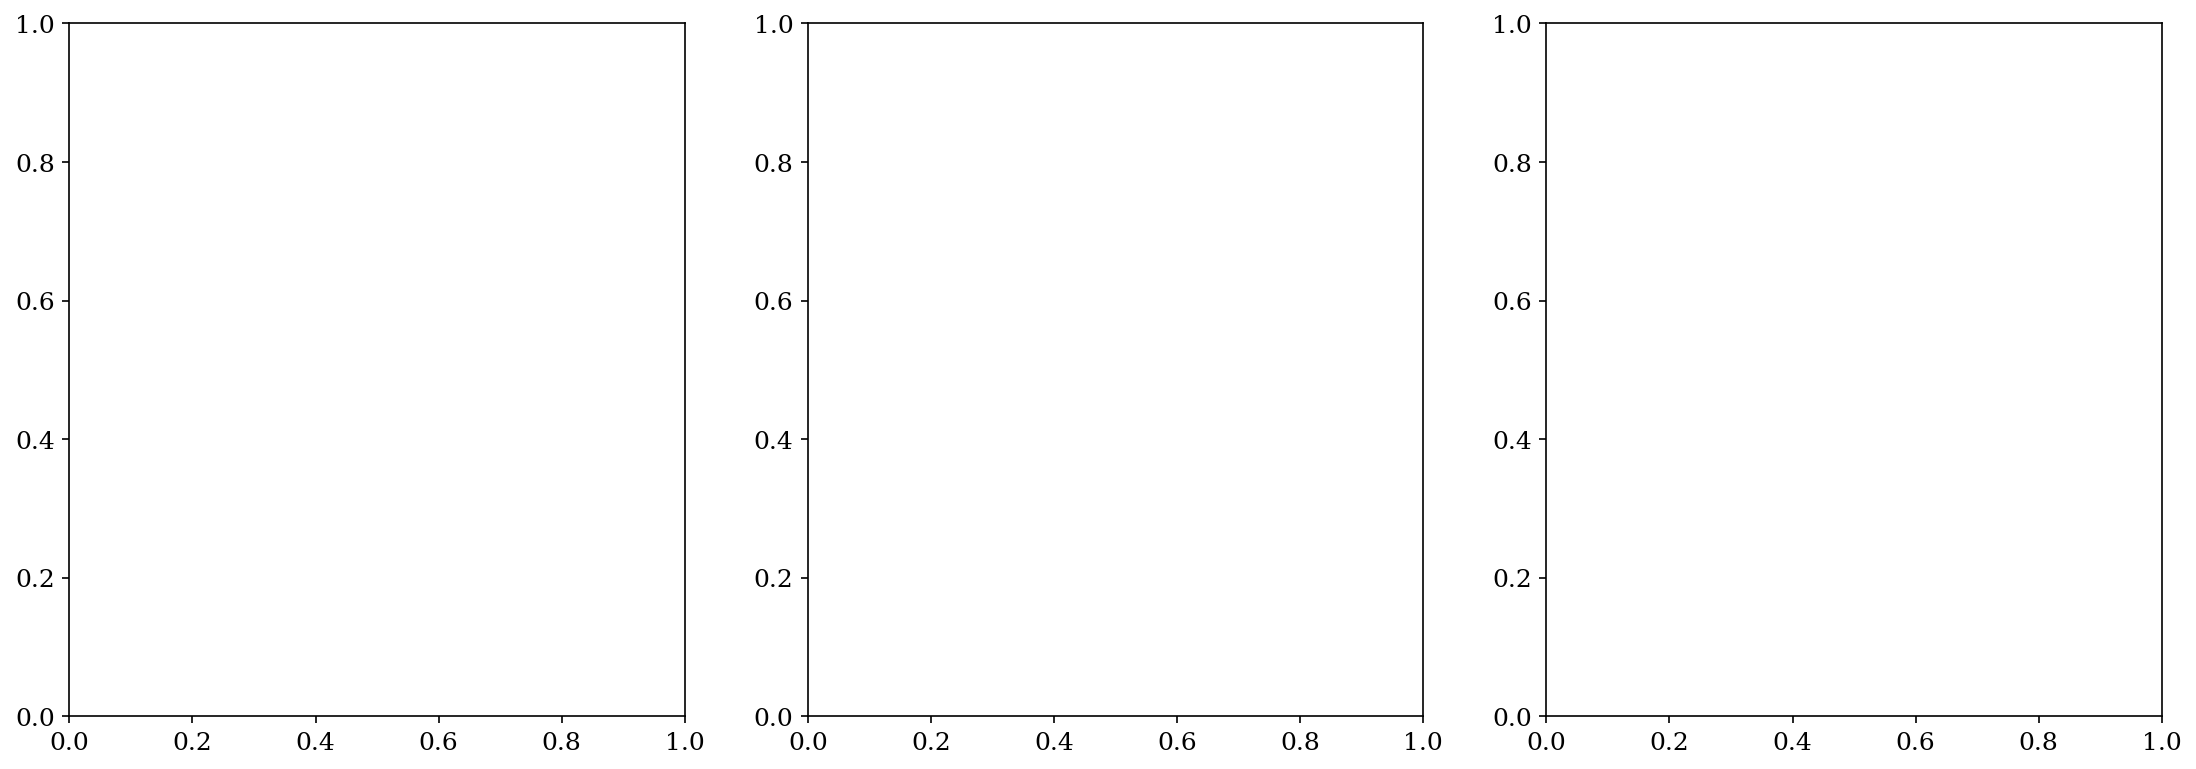

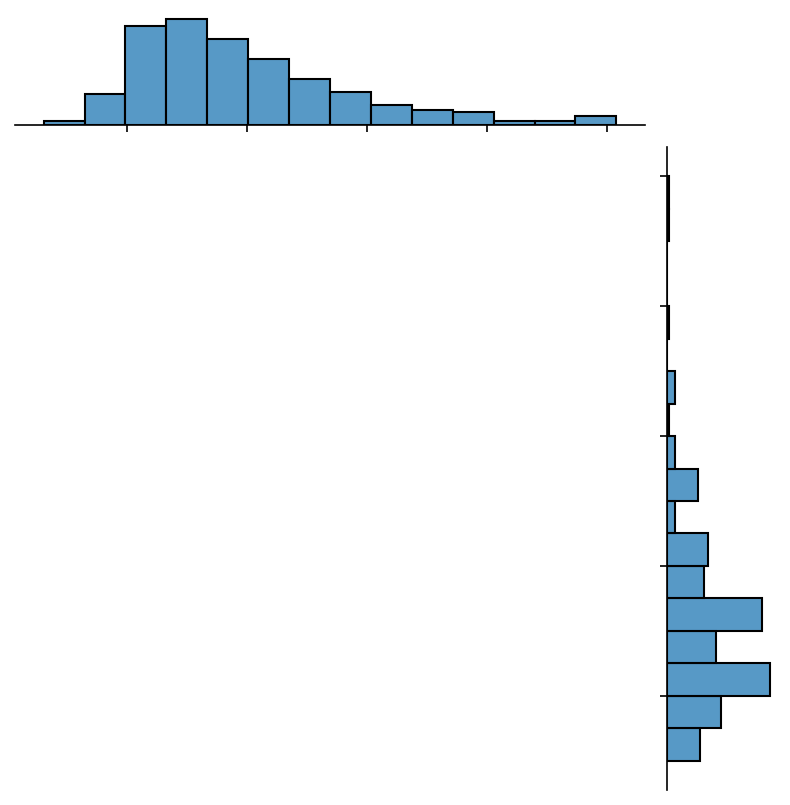

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

# Sample data
tips = sns.load_dataset("tips")

# Create a figure with 3 subplots side by side
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Function to plot a jointplot into an existing axis
def jointplot_in_ax(data, x, y, kind, ax):
    g = sns.jointplot(data=data, x=x, y=y, kind=kind)
    for ax_src, ax_dest in zip(g.fig.axes, ax.get_figure().axes):
        if ax_dest is not ax:
            continue
        ax_src.remove()
        fig._axstack.add(fig._make_key(ax_src), ax_src)
        fig.sca(ax_src)
    g.fig.set_figwidth(6)
    g.fig.set_figheight(6)
    g.fig.tight_layout()
    ax.remove()

# Create the first jointplot in the first subplot
jointplot_in_ax(tips, "total_bill", "tip", "scatter", axs[0])

# Create the second jointplot in the second subplot
jointplot_in_ax(tips, "total_bill", "size", "scatter", axs[1])

# Create the third jointplot in the third subplot
jointplot_in_ax(tips, "size", "tip", "scatter", axs[2])

plt.tight_layout()
plt.show()


In [6]:
andata = sc.read_visium(path=path_016)
andata.var["mt"] = andata.var_names.str.startswith("Mt-")
andata.var["ribo"] = andata.var_names.str.startswith(("RPS", "RPL"))
andata.var["hb"] = andata.var_names.str.contains("^HB[^(P)]")
sc.pp.calculate_qc_metrics(andata, qc_vars=["mt", "ribo", "hb"], inplace=True, log1p=True)

/gpfs/gsfs10/users/kanferg/conda/envs/squidpy/lib/python3.10/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/gpfs/gsfs10/users/kanferg/conda/envs/squidpy/lib/python3.10/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/gpfs/gsfs10/users/kanferg/conda/envs/squidpy/lib/python3.10/site-packages/scanpy/readwrite.py:476: DtypeWarning: Columns (1,2,3,4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  positions = pd.read_csv(


In [9]:
andata.obs.columns

Index(['in_tissue', 'array_row', 'array_col', 'n_genes_by_counts',
       'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts',
       'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes',
       'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes',
       'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt',
       'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo',
       'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb'],
      dtype='object')

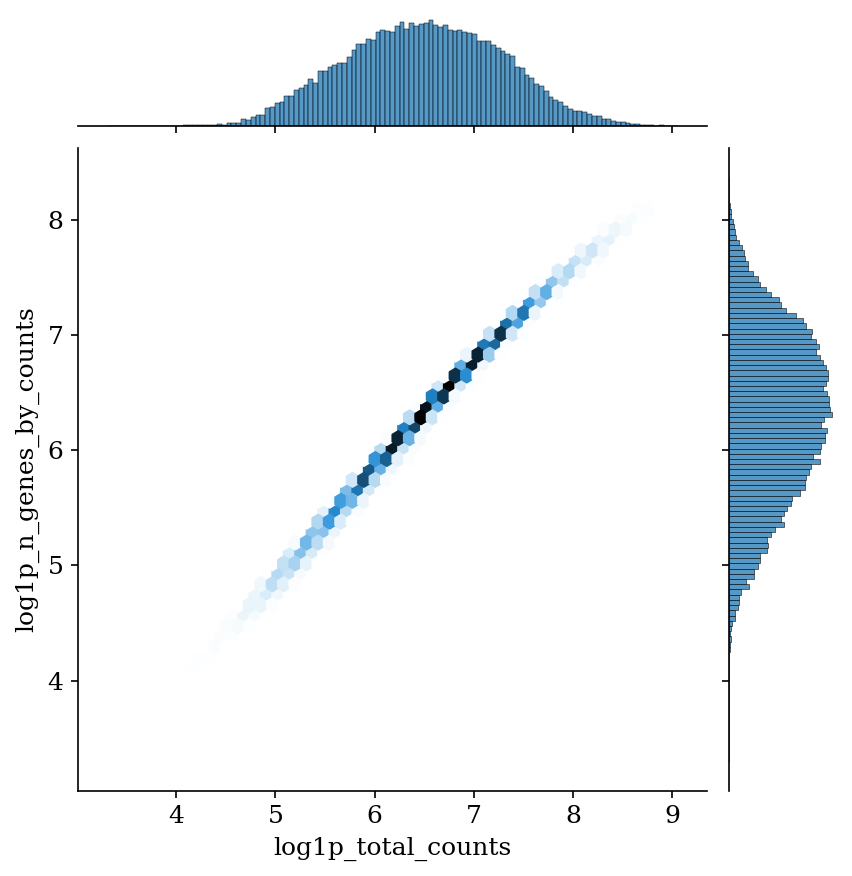

In [7]:
sns.jointplot(data=andata.obs,x="log1p_total_counts",y="log1p_n_genes_by_counts",kind="hex",)

/gpfs/gsfs10/users/kanferg/conda/envs/squidpy/lib/python3.10/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/gpfs/gsfs10/users/kanferg/conda/envs/squidpy/lib/python3.10/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/gpfs/gsfs10/users/kanferg/conda/envs/squidpy/lib/python3.10/site-packages/scanpy/readwrite.py:476: DtypeWarning: Columns (1,2,3,4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  positions = pd.read_csv(
/gpfs/gsfs10/users/kanferg/conda/envs/squidpy/lib/python3.10/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/gpfs/gsfs10/users/kanferg/conda/envs/squidpy/li

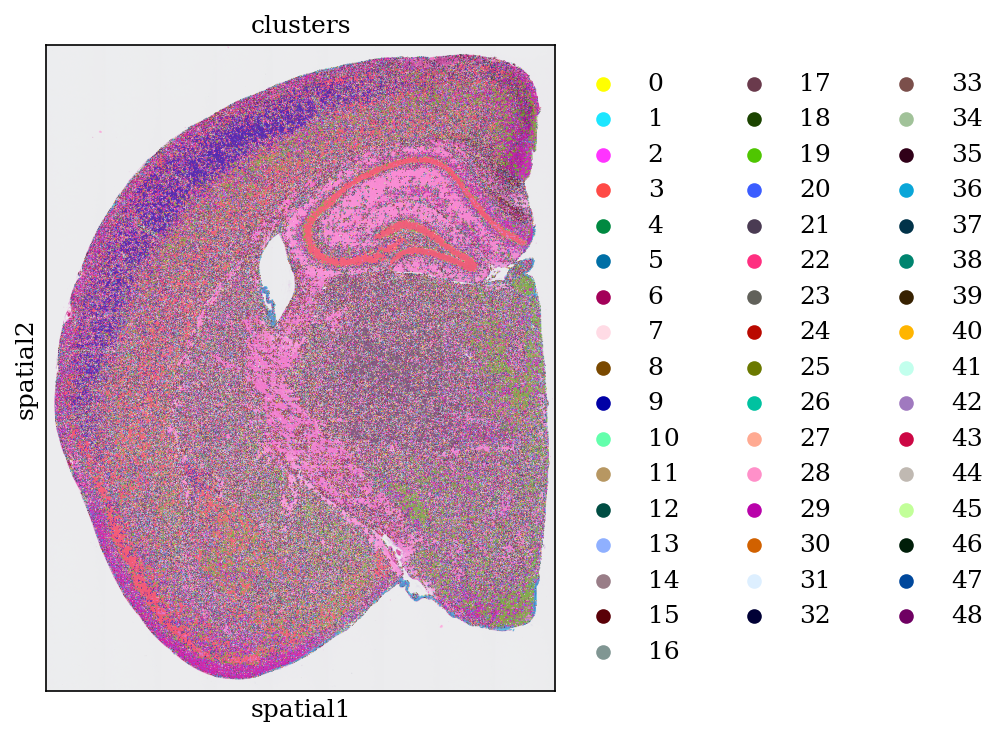

In [2]:
pathAdata = "/data/kanferg/Sptial_Omics/playGround/Data/Visium_HD_Mouse_Brain_square_example/square_008um"
adata = sc.read_visium(path=pathAdata)
sc.pp.filter_cells(adata, min_counts=50)
sc.pp.filter_cells(adata, min_genes=50)
sc.pp.filter_cells(adata, max_counts=1500)
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
sc.pp.pca(adata, n_comps=10)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.tl.leiden(adata, key_added="clusters", flavor="igraph", directed=False, n_iterations=2)
# Ensure the coordinates are a properly typed NumPy array
adata.obsm['spatial'] = np.array(adata.obsm['spatial'], dtype=np.float64)
# Plot
sq.pl.spatial_scatter(adata, color=["clusters"])

In [2]:
file_path = "/data/kanferg/Sptial_Omics/playGround/out/example_file.h5ad"
loaded_adata = sc.read_h5ad(file_path)

In [10]:
path = "/data/kanferg/Sptial_Omics/playGround/Data/Visium_HD_Mouse_Brain_square_example/square_008um/spatial"
file = "tissue_hires_image.png"
image = io.imread(os.path.join(path,file))
image_array = np.array(image)
print(f'{np.shape(image_array)}')

pathAdata =  "/data/kanferg/Sptial_Omics/playGround/Data/Visium_HD_Mouse_Brain_square_example/square_008um"
img = sq.im.ImageContainer(image_array, layer="img1")
adata = sc.read_visium(path = pathAdata)

(6000, 4729, 3)


/gpfs/gsfs10/users/kanferg/conda/envs/squidpy/lib/python3.10/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/gpfs/gsfs10/users/kanferg/conda/envs/squidpy/lib/python3.10/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/gpfs/gsfs10/users/kanferg/conda/envs/squidpy/lib/python3.10/site-packages/scanpy/readwrite.py:476: DtypeWarning: Columns (1,2,3,4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  positions = pd.read_csv(


In [11]:
adata

AnnData object with n_obs × n_vars = 393543 × 19059
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

In [12]:
sc.pp.filter_cells(adata, min_counts = 50)
sc.pp.filter_cells(adata, min_genes = 50)
sc.pp.filter_cells(adata, max_counts = 1500)
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
adata

/gpfs/gsfs10/users/kanferg/conda/envs/squidpy/lib/python3.10/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/gpfs/gsfs10/users/kanferg/conda/envs/squidpy/lib/python3.10/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 357701 × 19059
    obs: 'in_tissue', 'array_row', 'array_col', 'n_counts', 'n_genes'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial', 'log1p'
    obsm: 'spatial'

In [13]:
sc.pp.pca(adata, n_comps = 10)
sc.pp.neighbors(adata)

In [14]:
adata

AnnData object with n_obs × n_vars = 357701 × 19059
    obs: 'in_tissue', 'array_row', 'array_col', 'n_counts', 'n_genes'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial', 'log1p', 'pca', 'neighbors'
    obsm: 'spatial', 'X_pca'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [15]:
sc.tl.umap(adata)
adata

AnnData object with n_obs × n_vars = 357701 × 19059
    obs: 'in_tissue', 'array_row', 'array_col', 'n_counts', 'n_genes'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial', 'log1p', 'pca', 'neighbors', 'umap'
    obsm: 'spatial', 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [16]:
sc.tl.leiden(adata, key_added="clusters", flavor="igraph", directed=False, n_iterations=2)
adata

AnnData object with n_obs × n_vars = 357701 × 19059
    obs: 'in_tissue', 'array_row', 'array_col', 'n_counts', 'n_genes', 'clusters'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial', 'log1p', 'pca', 'neighbors', 'umap', 'clusters'
    obsm: 'spatial', 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [22]:
adata.obsm['spatial'] = np.array(adata.obsm['spatial'], dtype=np.float64)
adata.obsm['spatial']

array([[11776.20047345,  8988.20042418],
       [12812.94919716, 17761.30141825],
       [17972.74391189, 15142.99743472],
       ...,
       [14139.92325096, 16660.95969078],
       [14698.51847194, 11046.1646284 ],
       [ 3438.95598236, 17698.52119235]])

/gpfs/gsfs10/users/kanferg/conda/envs/squidpy/lib/python3.10/site-packages/squidpy/pl/_spatial_utils.py:483: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = color_source_vector.map(color_map)


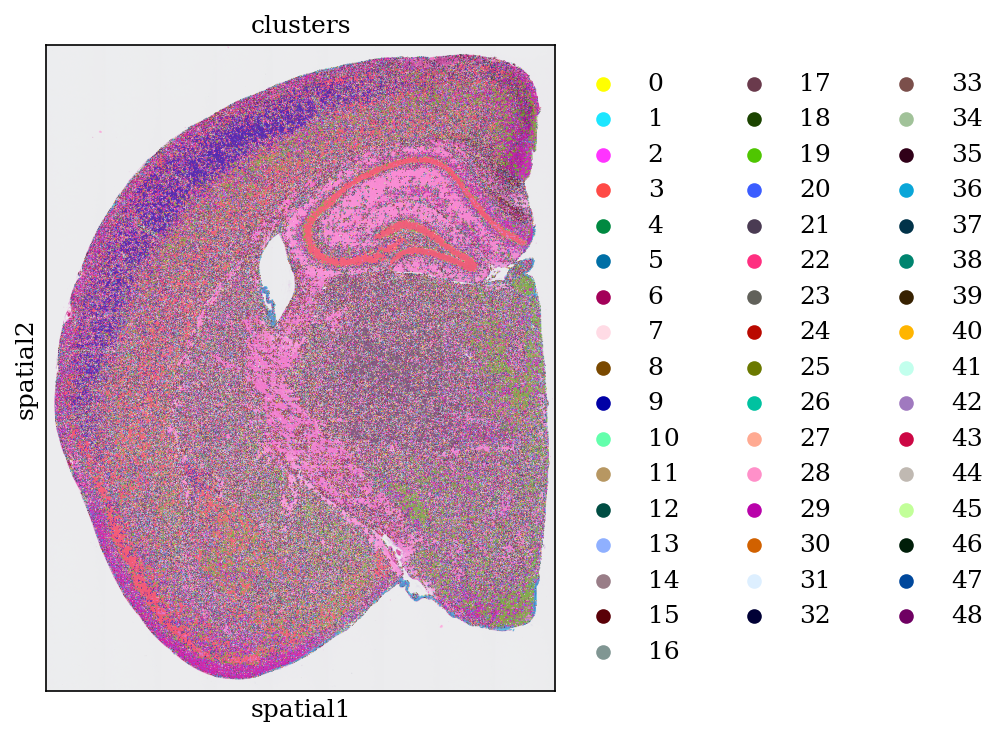

In [23]:
sq.pl.spatial_scatter(adata, color=["clusters"])

The issue with the `dtype=object` suggests that the coordinates array is not properly typed as a numeric array. To resolve this, we need to convert the array to a proper numeric type, such as `float`.

Here is the updated code to ensure the `spatial` key in `obsm` is properly typed:

```python
import squidpy as sq
import scanpy as sc
from skimage import io
import os
import numpy as np

path = "/data/kanferg/Sptial_Omics/playGround/Data/Visium_HD_Mouse_Brain_square_example/square_008um/spatial"
file = "tissue_hires_image.png"
image = io.imread(os.path.join(path, file))
image_array = np.array(image)
print(f'{np.shape(image_array)}')

pathAdata = "/data/kanferg/Sptial_Omics/playGround/Data/Visium_HD_Mouse_Brain_square_example/square_008um"
img = sq.im.ImageContainer(image_array, layer="img1")
adata = sc.read_visium(path=pathAdata)
sc.pp.filter_cells(adata, min_counts=50)
sc.pp.filter_cells(adata, min_genes=50)
sc.pp.filter_cells(adata, max_counts=1500)
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

sc.pp.pca(adata, n_comps=10)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.tl.leiden(adata, key_added="clusters", flavor="igraph", directed=False, n_iterations=2)

# Ensure the coordinates are a properly typed NumPy array
adata.obsm['spatial'] = np.array(adata.obsm['spatial'], dtype=np.float64)

# Plot
sq.pl.spatial_scatter(adata, color=["clusters"])
```

This conversion to `dtype=np.float64` should resolve the `TypeError` and allow the coordinates to be used correctly in the plotting function.

In [3]:
adata = sq.datasets.visium_hne_adata()

In [4]:
adata

AnnData object with n_obs × n_vars = 2688 × 18078
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_counts', 'leiden', 'cluster'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'cluster_colors', 'hvg', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'rank_genes_groups', 'spatial', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

## class for handle squdipy data from vizum hd expiment:

In [6]:
path = "/data/kanferg/Sptial_Omics/playGround/Data/Visium_HD_Mouse_Brain_square_example/square_008um/spatial"
file = "tissue_hires_image.png"
image = io.imread(os.path.join(path,file))
image_array = np.array(image)
print(f'{np.shape(image_array)}')

pathAdata =  "/data/kanferg/Sptial_Omics/playGround/Data/Visium_HD_Mouse_Brain_square_example/square_008um"
img = sq.im.ImageContainer(image_array, layer="img1")
adata = sc.read_visium(path = pathAdata)

for scale in [1.0, 2.0]:
    feature_name = f"features_summary_scale{scale}"
    sq.im.calculate_image_features(
        adata,
        img.compute(),
        features="summary",
        key_added=feature_name,
        n_jobs=4,
        scale=scale,
    )


# # combine features in one dataframe
# adata.obsm["features"] = pd.concat(
#     [adata.obsm[f] for f in adata.obsm.keys() if "features_summary" in f],
#     axis="columns",)
# # make sure that we have no duplicated feature names in the combined table
# adata.obsm["features"].columns = ad.utils.make_index_unique(
#     adata.obsm["features"].columns)

(6000, 4729, 3)


/gpfs/gsfs10/users/kanferg/conda/envs/squidpy/lib/python3.10/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/gpfs/gsfs10/users/kanferg/conda/envs/squidpy/lib/python3.10/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/gpfs/gsfs10/users/kanferg/conda/envs/squidpy/lib/python3.10/site-packages/scanpy/readwrite.py:476: DtypeWarning: Columns (1,2,3,4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  positions = pd.read_csv(


  0%|          | 0/393543 [00:00<?, ?/s]

/gpfs/gsfs10/users/kanferg/conda/envs/squidpy/lib/python3.10/site-packages/xarray/core/utils.py:494: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  warnings.warn(
/gpfs/gsfs10/users/kanferg/conda/envs/squidpy/lib/python3.10/site-packages/xarray/core/utils.py:494: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  warnings.warn(
/gpfs/gsfs10/users/kanferg/conda/envs/squidpy/lib/python3.10/site-packages/xarray/core/utils.py:494: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To acc

ValueError: Expected `height` to be in interval `[0, 6000]`, found `8988`.

In [ ]:
def cluster_features(features: pd.DataFrame, like=None) -> pd.Series:
    """
    Calculate leiden clustering of features.

    Specify filter of features using `like`.
    """
    # filter features
    if like is not None:
        features = features.filter(like=like)
    # create temporary adata to calculate the clustering
    adata = ad.AnnData(features)
    # important - feature values are not scaled, so need to scale them before PCA
    sc.pp.scale(adata)
    # calculate leiden clustering
    sc.pp.pca(adata, n_comps=min(10, features.shape[1] - 1))
    sc.pp.neighbors(adata)
    sc.tl.leiden(adata)

    return adata.obs["leiden"]


# calculate feature clusters
adata.obs["features_cluster"] = cluster_features(adata.obsm["features"], like="summary")

# compare feature and gene clusters
sq.pl.spatial_scatter(adata, color=["features_cluster", "cluster"])